In [55]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from livelossplot import PlotLosses
from apex import amp

<AxesSubplot:xlabel='5 Minutes'>

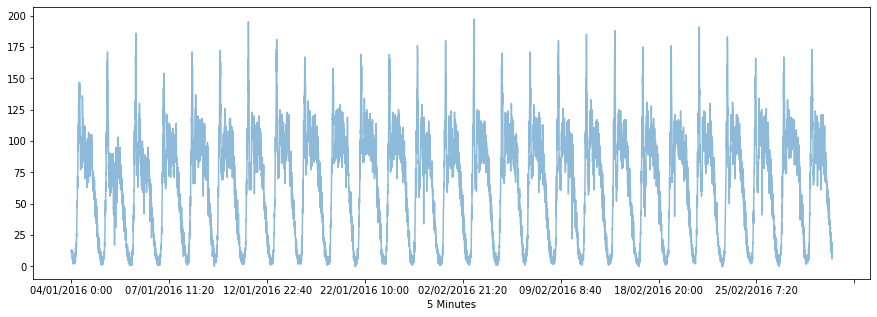

In [39]:
def load_csv_data(path, index_col):
    df = pd.read_csv(path,  index_col=index_col)
    df = df.astype('float')
    return df

df = load_csv_data('data/train.csv',  index_col='5 Minutes')
df['Lane 1 Flow (Veh/5 Minutes)'].plot(figsize=(15,5), alpha=0.5)

<AxesSubplot:xlabel='5 Minutes'>

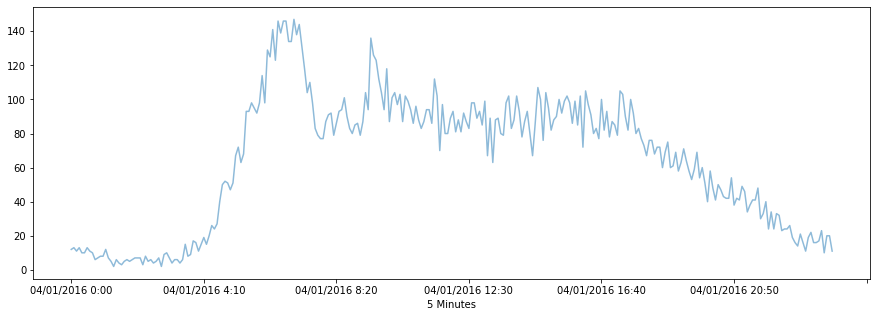

In [40]:
df['Lane 1 Flow (Veh/5 Minutes)'][:int(60*24/5)].plot(figsize=(15,5), alpha=0.5)

In [41]:
def create_data(df):
    indexs = list(df.index)
    indexs = [[i.split(' ')[0],i.split(' ')[1]] for i in indexs]
    # 生成了 xx xx xx xx
    indexs = [[dt[0].split('/')[0],dt[0].split('/')[1],dt[1].split(':')[0], dt[1].split(':')[1]] for dt in indexs]
    date_times = np.array(indexs).astype('float')
    flows = np.array(df['Lane 1 Flow (Veh/5 Minutes)'])
    # 维度弥补
    flows = flows[:,np.newaxis].astype('float')
    data = np.concatenate((date_times, flows),axis=1)
    return data

In [42]:
def generate_data_x_y(data):
    data_mean = np.mean(data,axis=0)
    data_std = np.std(data,axis=0)
    data = (data-data_mean)/data_std

    train_x = data[:-1]
    train_y = data[1:,4]
    train_x = torch.as_tensor(torch.from_numpy(train_x), dtype=torch.float32)
    train_y = torch.as_tensor(torch.from_numpy(train_y), dtype=torch.float32)

    return data_mean, data_std, train_x, train_y



In [43]:
class RegLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RegLSTM, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.reg = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )
    
    def forward(self, x):
        y = self.rnn(x)[0]
        batch_size, seq_len, hidden_size = y.shape
        y = y.contiguous().view(-1, hidden_size)
        
        y = self.reg(y)
        y = y.view(batch_size, seq_len, -1)
        
        return y

In [53]:
def loss_func(pred_y, data_y, loss_name):
    if loss_name == "custom":
        with torch.no_grad():
            weights = np.tanh(np.arange(seq_len) * (np.e / seq_len))
            weights = torch.tensor(weights, dtype=torch.float32, device=device)
        loss = ((pred_y - data_y[:,:,np.newaxis].cuda()).view(-1, seq_len) **2 * weights)
        loss = loss.mean()
    
    elif loss_name == "MSE":
        loss = nn.MSELoss(pred_y, data_y)
    
    return loss

In [45]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [65]:
def plot_train(net):
    net.eval()
    pred_x_1 = net(batch_var_x[-1].view(-1,seq_len,5).cuda()).view(-1).cpu().detach().numpy()
    plt.plot(pred_x_1, 'r', label='pred')
    plt.plot(batch_var_y[-1], 'b', label='real', alpha=0.3)
    plt.plot([batch_size, batch_size], [-1, 2], color='k', label='train | pred')

# 表现的太差了，我们试一试不用batch

In [46]:
def generate_train_data(batch_size, train_size, train_x, train_y):
        batch_var_x = []
        batch_var_y = []
        for i in range(batch_size):
                j = train_size - i
                batch_var_x.append(train_x[j:])
                batch_var_y.append(train_y[j:])

        batch_var_x = pad_sequence(batch_var_x, batch_first = True)
        batch_var_y = pad_sequence(batch_var_y, batch_first = True)

        return batch_var_x, batch_var_y

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data = create_data(df)
data_mean, data_std, train_x, train_y = generate_data_x_y(data)

input_size = train_x.shape[1]
output_size = 1
hidden_size = 10
num_layers = 1
seq_len = 128
batch_size = 32
train_size = train_x.shape[0]

batch_size = 12 *24  *7 * 2
seq_len = batch_size - 1

batch_var_x, batch_var_y = generate_train_data(batch_size, train_size, train_x, train_y)



'''Training'''

def train_model(epoch, data_x, data_y, loss_name):
    net = RegLSTM(input_size, hidden_size, output_size, num_layers).cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    net, optimizer = amp.initialize(net, optimizer, opt_level="O1")
    net.train()
    p_loss = PlotLosses()
    logs = {}
    loss_value_list = []
    e_tqdm = tqdm(range(epoch))

    for e in e_tqdm:
        pred_y = net(data_x.cuda())

        loss = loss_func(pred_y, data_y, loss_name = 'custom')
        
        optimizer.zero_grad()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()

        # plot
        loss_value_list.append(loss.item())
        logs['loss'] = loss.item()
        e_tqdm.set_description('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
        p_loss.update(logs)
        p_loss.send()
    return net



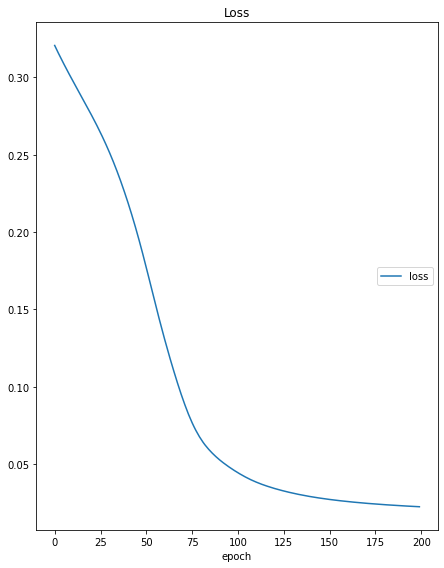

Epoch:  199, Loss: 0.02242: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s]

Loss
	loss             	 (min:    0.022, max:    0.321, cur:    0.022)


In [71]:
# loss = 'custom'
net = train_model(epoch=200, data_x=batch_var_x, data_y=batch_var_y, loss_name='custom')
save_model(net, './custom_loss.pkl')

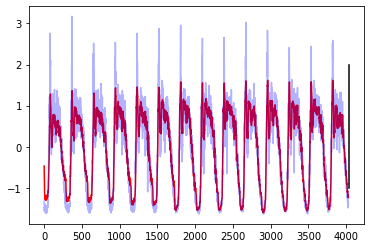

In [72]:
plot_train(net)

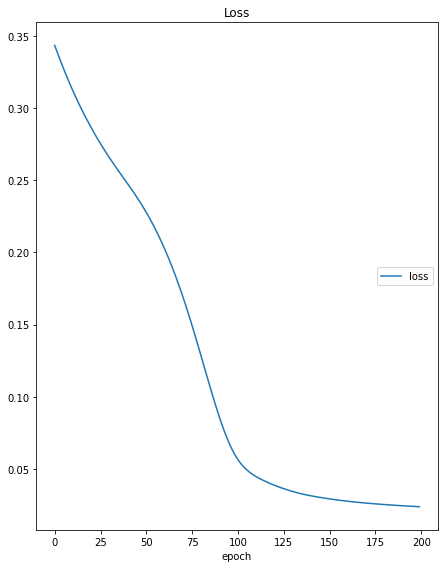

Epoch:  199, Loss: 0.02396: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s]

Loss
	loss             	 (min:    0.024, max:    0.343, cur:    0.024)


In [69]:
# loss = 'MSE'
net = train_model(epoch=200, data_x=batch_var_x, data_y=batch_var_y, loss_name='MSE')
save_model(net, './MSE_loss.pkl')

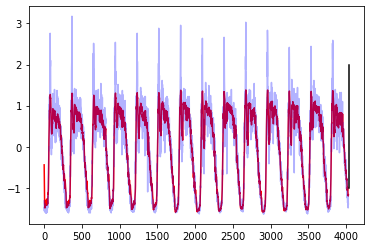

In [70]:
net.load_state_dict(torch.load('MSE_loss.pkl'))
plot_train(net)

# TESTING

<AxesSubplot:xlabel='5 Minutes'>

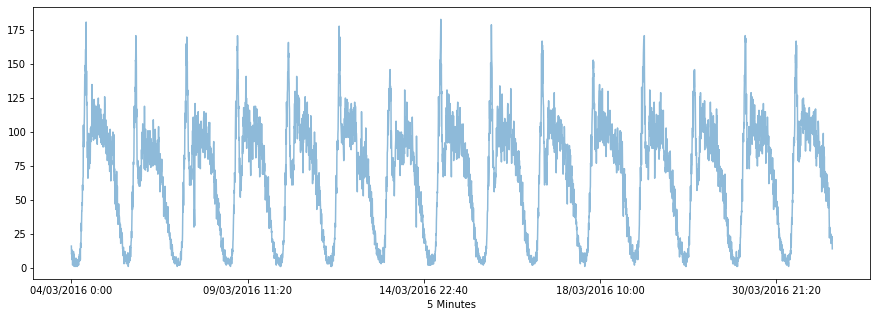

In [73]:
df = load_csv_data('data/test.csv',  index_col='5 Minutes')
df['Lane 1 Flow (Veh/5 Minutes)'].plot(figsize=(15,5), alpha=0.5)

In [85]:
data = create_data(df)
data = (data-data_mean)/data_std
test_x = data[:-1]
test_y = data[1:,4]
test_x = torch.as_tensor(torch.from_numpy(test_x), dtype=torch.float32)
test_y = torch.as_tensor(torch.from_numpy(test_y), dtype=torch.float32)

In [108]:
net.load_state_dict(torch.load('custom_loss.pkl'))
res = []
for i in range(12*24, test_x.shape[0]):
    # 按理说这个pred_test_y是和test_y[12*24+i]等同的地位
    pre_test_y = net(test_x[:i].view(1, -1, 5).cuda()).view(-1)[-1]
    res.append(pre_test_y.cpu().detach().numpy())

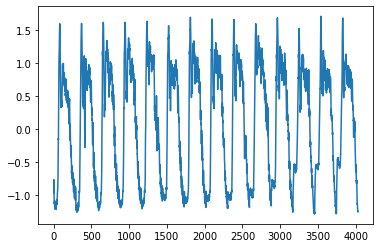

In [113]:
plt.plot(res)

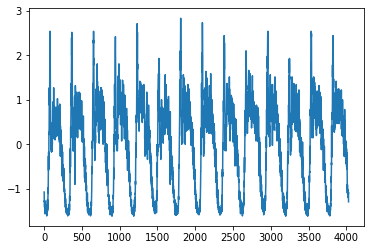

In [114]:
plt.plot(test_y[12*24:])

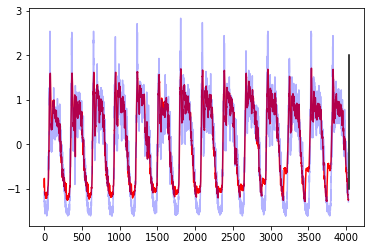

In [115]:
plt.plot(res, 'r', label='pred')
plt.plot(test_y[12*24:], 'b', label='real', alpha=0.3)
plt.plot([len(res), len(res)], [-1, 2], color='k', label='train | pred')